# NeXus reference frames

Reference frames or coordinate systems are used in several NeXus base classes. Here we extend the NeXus class documentation regarding reference frames with mathematical background and examples.

1. [NXtransformations reference frame](#NXtransformations-reference-frame)
2. [NXsample reference frame](#NXsample-reference-frame)
3. [NXdata reference frame](#NXdata-reference-frame)
4. [Euclidean space](#Euclidean-space)
    1. [Reference frame](#Reference-frame)
    2. [Change of reference frame](#Change-of-reference-frame)
    3. [Homogeneous coordinates](#Homogeneous-coordinates)
    4. [Homographies](#Homographies)
    5. [Metric tensor](#Metric-tensor)
    6. [Dual basis](#Dual-basis)
    7. [Crystallography](#Crystallography)
        1. [Lattice](#Lattice)
        2. [Diffraction](#Diffraction)
        1. [Busing and Levy convention](#Busing-and-Levy-convention)
           1. [Reciprocal basis](#Reciprocal-basis)
           2. [Orientation](#Orientation)
5. [Example utilities](#Example-utilities)
    1. [Diffraction](#Diffraction)
    2. [Plotting](#Plotting)
    3. [Saving](#Saving)
6. [Examples](#Examples)
    1. [NXdata crystallography example](#NXdata-crystallography-example)

# NXtransformations reference frame

The default reference frame in Nexus is the [Nexus reference frame](https://manual.nexusformat.org/design.html#the-nexus-coordinate-system) which is the [standard Euclidean basis](#Reference-frame) with additional conventions for position and orientation of source, sample, detector and other objects.

Objects can be positioned in this reference frame by chaining [proper rigid transformations](#Homographies). The [NXtransformations](https://manual.nexusformat.org/classes/base_classes/NXtransformations.html) allow for the representation of such chain: translations are representation by vectors, rotations are represented by _rotation vectors_ (direction and angle) and directions allow defining a different reference frame than the Nexus reference frame. Together the chain of transformation defines an [activate transformation matrix](#Change-of-reference-frame) in [homogeneous coordinates](#Homogeneous-coordinates).

```
myentry:NXentry
  instrument:NXinstrument
     mydetector:NXdetector
     depends_on = "diffr/gravity"
     diffr:NXtransformations
       gravity = float64(0)
       @transformation_type=direction
       @vector=0,0,-1
       
       beam = float64(0)
       @transformation_type=direction
       @vector=1,0,0
       @depends_on=beam
       
       distance = float64(10)
       @transformation_type=translation
       @vector=1,0,0
       @depends_on=beam
       
       roll = float64(20)
       @transformation_type=rotation
       @vector=0,0,1
       @depends_on=distance
       
       pitch = float64(30)
       @transformation_type=rotation
       @vector=0,1,0
       @depends_on=roll
```

In this example we define the reference frame having the Z-axis being vertical and pointing upwards and the X-axis pointing along the beam. Within that reference frame the detector is translated downstream along the beam and than rolled and pitched. The coodinates of a detector pixel in tge laboratory reference frame is given by

$$
X_\text{lab} = R_y(30) . R_z(20). T_x(10) . X_\text{pixel}
$$

where `R` and `T` are activate transformation matrices for rotation and translation with respect to a specific axis.

# NXsample reference frame

[NXtransformations](https://manual.nexusformat.org/classes/base_classes/NXtransformations.html) can be used to define a reference frame and position a sample

```
myentry:NXentry
  instrument:NXinstrument
     mydetector:NXsample
     depends_on = "diffr/phi"
     diffr:NXtransformations
       phi = float64(0)
       @transformation_type=rotation
       @vector=0,1,0
       @depends_on=chi
       chi = float64(0)
       @transformation_type=rotation
       @vector=0,0,1
       @depends_on=rotation_angle
       rotation_angle = float64(0)
       @transformation_type=rotation
       @vector=0,1,0
```

When the sample is a single crystal, its orientation can defined by a so-called UB-matrix (the _ub_matrix_ field of [NXsample](https://manual.nexusformat.org/classes/base_classes/NXsample.html)).


# NXdata reference frame

The axis values in [NXdata](https://manual.nexusformat.org/classes/base_classes/NXdata.html) are the coordinates with respect the reference frame in which the data is plotted.

We will refer to the _data frame_ as the reference frame in which the axis coordinates are provided and the _plotting frame_ as the reference frame in which data is to be displayed.

Example in $\mathbb{R}^3$:

```
myplot:NXdata
  @axes = ['Ql', 'Qk', 'Qh']
  @passive_transformation = "reciprocal_space"
  Qh = float64(1601)
    @long_name = 'H (rlu)'
  Qk = float64(801)
    @long_name = 'K (rlu)'
  Ql = float64(1201)
    @long_name = 'L (rlu)'
  reciprocal_space = float64(4, 4)
    @transformation_type = 'affine'
```

The $(n+1) \times (n+1)$ matrix is the [change-of-frame matrix](#Change-of-reference-frame) or _passive transformation matrix_. It defines a [homography](#Homographies) in [homogeneous coordinates](#Homogeneous-coordinates)

$$
F=\begin{bmatrix}
C_{n\times n}&T_{n\times 1}\\
P_{1\times n}&1
\end{bmatrix}
$$

where $T$ is the position of the origin of the plotting frame in the data frame and the columns of $C$ are the coordinates of the basis vectors of the plotting frame with respect to the basis of the data frame. $P$ can be used to describe projective transformations like the projections of a sample on a flat detector in full field techniques.

The transformation type is an optional attribute (enumeration) that describes the type of transformation. This can be useful for plotting applications to check whether the provided transformation is supported.

* translation
* proper rigid: translation + rotations
* rigid: proper rigid + reflections
* similarity: rigid + isotropic scaling
* affine: similarity + non-isotropic scaling and shear
* linear: affine without translation
* homography: affine + projection

Note that the [NXdata](https://manual.nexusformat.org/classes/base_classes/NXdata.html) fields _offset_ and _scaling_factor_ should be used to get the real axis values from the stored axis values. These two factors could in principle also be absorbed in the passive transformation matrix.

Most plotting libraries support at least up to affine transformations. [This example](#Plotting) demonstrates the plotting of an image  with an affine transformation in $\mathbb{R}^2$ using the popular python plotting library _matplotlib_.

Note that the change-of-basis matrix is related to the length of the basis vectors and the angles between the basis vectors. For example in $\mathbb{R}^3$

$$
C^TC=\begin{bmatrix}
a^2 & ab\cos\gamma & ac\cos\beta\\
ab\cos\gamma & b^2 & bc\cos\alpha\\
ac\cos\beta & bc\cos\alpha & c^2
\end{bmatrix}
$$

where $a$, $b$ and $c$ then lengths and $\alpha$, $\beta$ and $\gamma$ the angles.

# Euclidean space

The mathematics of all reference frames used in NeXus takes place in _Euclidian space_.

Euclidian space $\mathbb{E}^n$ is an affine space over $\mathbb{R}^n$ with the Euclidian inner product (a.k.a. the dot product)
$$
\langle.,.\rangle:\mathbb{R}^n\times\mathbb{R}^n\to\mathbb{R}:(\vec{u},\vec{v}) \mapsto \sum_{i=1}^n u_iv_i
$$

## Reference frame
The coordinates $(a_1, \dots, a_n)$ with $a_i\in\mathbb{R}$ of a point $a$ are defined with respect the a reference frame $(o, \vec{b}_1, \dots, \vec{b}_n)$ where $o$ is the origin and $\vec{b}_i$ the basis vectors so that

$$
\vec{oa}=a_1\vec{b}_1+\dots+a_n\vec{b}_n
$$

The standard reference frame of Eucledian space is the right-handed orthonormal frame with the following basis

$$
\begin{align*}
\vec{e}_1=\begin{pmatrix}1\\0\\\vdots\\0\end{pmatrix} &&
\vec{e}_2=\begin{pmatrix}0\\1\\\vdots\\0\end{pmatrix} &
&\ldots &&
\vec{e}_n=\begin{pmatrix}0\\0\\\vdots\\1\end{pmatrix}
\end{align*}
$$

## Change of reference frame
If $(a_1, \dots, a_n)$ are the coordinates with respect to reference frame $(o, \vec{b}_1, \dots, \vec{b}_n)$ and $(a_1^\prime, \dots, a_n^\prime)$ are the coordinates with respect to reference frame $(o^\prime, \vec{b}_1^\prime, \dots, \vec{b}_n^\prime)$ then those coordinates are related by

$$
\begin{bmatrix}A\\1\end{bmatrix}=
\begin{bmatrix}
C_{n\times n}&T_{n\times 1}\\
P_{1\times n}&1
\end{bmatrix}
\begin{bmatrix}A^\prime\\1\end{bmatrix}
$$

where

* $A$ are the coordinates $(a_1, \dots, a_n)$
* $A^\prime$ are the coordinates $(a_1^\prime, \dots, a_n^\prime)$
* $T$ are the coordinates of vector $\vec{oo^\prime}$ in reference frame $(o, \vec{b}_1, \dots, \vec{b}_n)$
* the columns of $C$ are the coordinates of $\vec{b}_i^\prime$ with respect to $(\vec{b}_1, \dots, \vec{b}_n)$
* $P$ are zeros.

We call $T$ the _translation vector_, $C$ the _change-of-basis matrix_ and the composite $F$ the _change-of-frame matrix_ or _passive transformation matrix_. Note that this matrix maps coordinates from the new frame to the old frame. The _coordinate transformation matrix_ or _active transformation matrix_ which maps coordinates from the old frame to the new frame is the inverse of the _change-of-frame matrix_. Note that the inverse may not exist.

## Homogeneous coordinates

The homogeneous coordinates $(h_1, \ldots, h_n, h_{n+1})$ of point $a$ with $h_{i}\in\mathbb{R}$ and $h_{n+1}\neq 0$ are defined so that

$$
a_i=\frac{h_i}{h_{n+1}}
$$

The coordinates $(a_1, \dots, a_n, 1)$ are a special case of homogeneous coordinates.

## Homographies

A homography is a transformation can be represented be the following _change-of-frame matrix_

$$
F=\begin{bmatrix}
C_{n\times n}&T_{n\times 1}\\
P_{1\times n}&1
\end{bmatrix}
$$

Different transformation types can be distinguished based on the properties of the _translation vector_ $T$, _change-of-basis matrix_ $C$ and _projection vector_ $P$

* _translation_:
   * $C$ is the identity matrix and $P$ are all zeros
* _proper rigid (euclidian) transformation_:
   * $P$ are all zeros
   * $C$ is any orthogonal matrix ($C^T=C^{-1}$) with determinant $\det{C}=+1$
   * preserves angles, distances and handedness
   * translation + rotation
* _rigid (euclidian) transformation_:
   * $P$ are all zeros
   * $C$ is any orthogonal matrix ($C^T=C^{-1}$)
   * preserves angles and distances
   * proper rigid transformation + reflection
* _similarity transformation_:
   * $P$ are all zeros
   * $C=rA$ where A any orthogonal matrix ($A^T=A^{-1}$) and $r>0$
   * preserves angles and ratios between distances
   * rigid transformation + isotropic scaling
* _affine transformation_:
   * $P$ are all zeros
   * $C$ is any invertible matrix (i.e. linear transformation)
   * preserves parallelism
   * similarity transformation + non-isotropic scaling and shear
* _projective transformation (homography)_:
   * $C$ is any invertible matrix (i.e. linear transformation)
   * preserves collinearity
   * affine transformation + projection

The chained _NXtransformations_ allows the definition of a _proper rigid transformations_ because it is meant to position objects like sample, optics and detectors.

Possitive rotations around the x-, y- and z-axis of the standard Euclidean basis in $\mathbb{R}^3$ are defined by

$$
R_x(\theta) = \begin{bmatrix}
1 & 0 & 0\\
0 & \cos\theta & \sin\theta\\
0 & -\sin\theta & \cos\theta
\end{bmatrix}
$$

$$
R_y(\theta) = \begin{bmatrix}
\cos\theta & 0 & -\sin\theta\\
0 & 1 & 0\\
\sin\theta & 0 & \cos\theta\\
\end{bmatrix}
$$

$$
R_z(\theta) = \begin{bmatrix}
\cos\theta & \sin\theta & 0\\
-\sin\theta & \cos\theta & 0\\
0 & 0 & 1
\end{bmatrix}
$$

## Metric tensor

If $A$ and $B$ are the coordinates of $\vec{oa}$ and $\vec{ob}$ with respect to a basis $C$ given in the standard Euclidean basis (i.e. the columns are the coordinates of the basis in the standard Euclidean basis) then

$$
\langle\vec{oa},\vec{ob}\rangle = A^T\cdot C^T\cdot C\cdot B = A^T\cdot M\cdot B
$$

where $M$ is the _metric tensor_ of the basis $C$. Each element of $M$ is the dot product of two basis vectors

$$
M_{i,j}=\langle\vec{b}_i,\vec{b}_j\rangle
$$

The metrix tensor of the standard Euclidean basis is the identity matrix.

## Dual basis

The _dual basis_ $(b^1,\dots,b^n)$ of basis $(b_1,\dots,b_n)$ is defined as the basis for which

$$
\langle\vec{b^i},\vec{b}_i\rangle=\delta_{i,j}
$$

If $C_{b}$ and $C_{b^\ast}$ define a basis and its dual basis with respect to the standard Euclidean basis (i.e. the columns are the coordinates in the standard Euclidean basis) then

$$
C_{b^\ast}=C_{b}^{-T}
$$

and the metrix tensors of the two bases are eachothers inverse

$$
M_{b^\ast}=M_{b}^{-1}
$$

Note: in crystallography the dual basis of a lattice basis is referred to as the _recipocal basis_ which spans _reciprocal space_. The metrix tensor $M$ is referred to as the _Gram matrix_ $G$.

## Crystallography

### Lattice
In crystallography the _lattice parameters_ $(a, b, c, \alpha, \beta, \gamma)$ describe the metric tensor of the lattice basis

$$
M=\begin{bmatrix}
a^2 & ab\cos\gamma & ac\cos\beta\\
ab\cos\gamma & b^2 & bc\cos\alpha\\
ac\cos\beta & bc\cos\alpha & c^2
\end{bmatrix}
$$

The full description of the lattice basis however is given by $C$ (the coordinates of the lattic basis vectors with respect to the standard Euclidean basis). The extra three parameters describe the orientation of the lattice basis in the standard Euclidean basis.

The recipical lattice parameters $(a^\ast, b^\ast, c^\ast, \alpha^\ast, \beta^\ast, \gamma^\ast)$ describe the metric tensor in recipocal space
$$
M^\ast=\begin{bmatrix}
a^\ast a^\ast & a^\ast b^\ast\cos\gamma^\ast & a^\ast c^\ast\cos\beta^\ast\\
a^\ast b^\ast\cos\gamma^\ast & b^\ast b^\ast & b^\ast c^\ast\cos\alpha^\ast\\
a^\ast c^\ast\cos\beta^\ast & b^\ast c^\ast\cos\alpha^\ast & c^\ast c^\ast
\end{bmatrix}
$$

The full description of the reciprocal lattice basis however is given by $C^\ast$ (the coordinates of the lattic basis vectors with respect to the standard Euclidean basis). The extra three parameters describe the orientation of the recipcrocal lattice basis in the standard Euclidean basis.

### Diffraction

A vector $\vec{h}$ with integral coordinates $H^\ast$ with respect to the reciprocal lattice basis is a _lattice vector_. The coordinates are called _Miller indices_.

The _scattering vector_ $\vec{q}$ is the different between the the outgoing and incomming _wave vectors_ $\vec{k}$ and $\vec{k}_{0}$

$$
\begin{aligned}
\vec{q} &= \vec{k}-\vec{k}_{0}\\
\lVert\vec{k}\rVert &= \frac{2\pi}{\lambda}\\
\lVert\vec{k}_{0}\rVert &= \frac{2\pi}{\lambda}
\end{aligned}
$$

where $\lambda$ the wavelength of the primary beam.

Constructive interference can occur if symmetry allows it for a lattice vector $\vec{h}$ and a primary beam $\vec{k}_{0}$ in the direction of $\vec{k}$ when
$$
\vec{q} = 2\pi \vec{h}
$$

That's fancy way of saying we detect a non-zero scattered intensity in the direction of $\vec{k}$.

### Busing and Levy convention

W. R. Busing and H. A. Levy (Acta Cryst. (1967). 22, 457-464) define conventions which are followed by the Nexus standard.

#### Reciprocal basis

The reciprocal basis with respect to the standard Euclidean basis is chosen to be

$$
\begin{aligned}
\langle\vec{b^1},\vec{e}_1\rangle &= a^\ast \\
\langle\vec{b^1}\times \vec{b^2},\vec{e}_2\rangle &= 0
\end{aligned}
$$

As a consequence the associated change-of-basis matrix $C^\ast$, denoted as the matrix $B$, is given by

$$
B=\begin{bmatrix}
a^\ast & b^\ast\cos\gamma^\ast & c^\ast\cos\beta^\ast\\
0 & b^\ast\sin\gamma^\ast & -c^\ast\sin\beta^\ast\cos\alpha\\
0 & 0 & \frac{1}{c}
\end{bmatrix}
$$

#### Orientation

The crystal is randomly mounted on a diffractometer and with all diffractometer angles set to zero, the coordinates $H$ of a vector $\vec{h}$ with respect to the standard Euclidean basis can be calculated from the coordinates $H^\ast$ with respect to the reciprocal lattice basis

$$
H=UBH^\ast
$$

where $U$ the _orientation matrix_. Integral coordinates $H^\ast$ are referred to as _Miller indices_ and are the coordinates of the _lattice vectors_. The inverse of the norm of a lattice vector is the _d-spacing_ and the lattice vector is normal to the lattice planes associated to the Miller indices.

For a 3-circle diffractometer the sample can be rotated by

$$
Q=R_z(\omega) R_y(-\chi) R_z(\phi)H
$$

where $(\omega, \chi, \phi)$ is referred to as the _sample orientation_.

The _NXsample_ class defines these fields 

* _unit_cell_: lattice parameters $(a, b, c, \alpha, \beta, \gamma)$
* _orientation_matrix_: the orthogonal $U$ matrix
* _sample_orientation_: 3-circle diffractometer angles $(\omega, \chi, \phi)$
* _ub_matrix_: the matrix product $UB$

# Example utilities

Here we define some methods for the examle

## Diffraction

Some useful helper functions for crystallography

In [1]:
import numpy
from scipy import constants
from scipy.constants import physical_constants


def cos(angle_deg):
    return numpy.cos(numpy.radians(angle_deg))


def sin(angle_deg):
    return numpy.sin(numpy.radians(angle_deg))


def arccos(cosangle):
    return numpy.degrees(numpy.arccos(cosangle))


def lattice_to_metrix_tensor(lattice):
    aa = lattice["a"] ** 2
    bb = lattice["b"] ** 2
    cc = lattice["c"] ** 2
    bc = lattice["b"] * lattice["c"] * cos(lattice["alpha"])
    ac = lattice["a"] * lattice["c"] * cos(lattice["beta"])
    ab = lattice["a"] * lattice["b"] * cos(lattice["gamma"])
    return numpy.array([[aa, ab, ac], [ab, bb, bc], [ac, bc, cc]])


def metric_tensor_to_lattice(M):
    lattice = dict()
    lattice["a"] = M[0, 0] ** 0.5
    lattice["b"] = M[1, 1] ** 0.5
    lattice["c"] = M[2, 2] ** 0.5
    lattice["alpha"] = arccos(M[1, 2] / (lattice["b"] * lattice["c"]))
    lattice["beta"] = arccos(M[0, 2] / (lattice["a"] * lattice["c"]))
    lattice["gamma"] = arccos(M[0, 1] / (lattice["a"] * lattice["b"]))
    return lattice


def lattice_to_reciprocal_lattice(lattice):
    M = lattice_to_metrix_tensor(lattice)
    Mr = numpy.linalg.inv(M)
    return metric_tensor_to_lattice(Mr)


def busing_levy_reciprocal_basis(lattice):
    rlattice = lattice_to_reciprocal_lattice(lattice)
    br1 = [rlattice["a"], 0, 0]
    br2 = [
        rlattice["b"] * cos(rlattice["gamma"]),
        rlattice["b"] * sin(rlattice["gamma"]),
        0,
    ]
    br3 = [
        rlattice["c"] * cos(rlattice["beta"]),
        -rlattice["c"] * sin(rlattice["beta"]) * cos(lattice["alpha"]),
        1 / lattice["c"],
    ]
    return numpy.array([br1, br2, br3]).T


def rotx(angle):
    c = cos(angle)
    s = sin(angle)
    return numpy.array([[1, 0, 0], [0, c, -s], [0, s, c]])


def roty(angle):
    c = cos(angle)
    s = sin(angle)
    return numpy.array([[c, 0, -s], [0, 1, 0], [s, 0, c]])


def rotz(angle):
    c = cos(angle)
    s = sin(angle)
    return numpy.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])


def simplified_diffraction(Q, C, N):
    # Q: p x n  (rows are the coordinates)
    # C: n x n  (columns are the basis vectors)
    # N: n      (number of unit cells in each direction)
    # returns: p
    if Q.ndim == 1:
        Q = Q[numpy.newaxis, :]  # 1 x n
    x = (Q.dot(C)).T / 2  # n x p
    M = numpy.array(N)[:, numpy.newaxis]  # n x 1
    with numpy.errstate(divide="ignore", invalid="ignore"):
        g = numpy.sin(x * M) ** 2 / numpy.sin(x) ** 2
    for gi, Ni in zip(g, N):
        gi[numpy.isnan(gi)] = Ni**2
    g = numpy.product(g, axis=0)
    transmission = numpy.all(numpy.abs(x) < (numpy.pi / 2), axis=0)
    g[transmission] *= 2
    return g


kev_angstrom_factor = (
    constants.h * constants.c * 1e7 / physical_constants["electron volt"][0]
)


def wavelength(energy_keV):  # m
    return kev_angstrom_factor / energy_keV * 1e10


def wavenumber(energy_keV):  # m^-1
    return 2 * numpy.pi / wavelength(energy_keV)


def test_utilities():
    lattice = {"a": 1, "b": 1.2, "c": 1.3, "alpha": 70, "beta": 60, "gamma": 80}

    # Test metric tensor
    M = lattice_to_metrix_tensor(lattice)
    Mr = numpy.linalg.inv(M)
    lattice2 = metric_tensor_to_lattice(M)
    numpy.testing.assert_allclose(list(lattice.values()), list(lattice2.values()))

    # Test reciprocal lattice basis
    B = busing_levy_reciprocal_basis(lattice)
    numpy.testing.assert_allclose(Mr, B.T.dot(B))

    # Test lattice basis
    C = numpy.linalg.inv(B.T)
    numpy.testing.assert_allclose(M, C.T.dot(C))

    # Test norm
    h = numpy.array([1, 2, 3])
    norm1 = sum(B.dot(h) ** 2) ** 0.5
    norm2 = (h.dot(Mr).dot(h)) ** 0.5
    numpy.testing.assert_allclose(norm1, norm2)

    # Test diffraction
    N = numpy.array([1, 2, 3])
    h = numpy.array([2, 2, 0])
    Q = 2 * numpy.pi * B.dot(h)
    intensity = simplified_diffraction(Q, C, N)
    numpy.testing.assert_allclose(intensity, numpy.product(N**2))
    h = numpy.array([0, 0, 0])
    Q = 2 * numpy.pi * B.dot(h)
    intensity = simplified_diffraction(Q, C, N)
    numpy.testing.assert_allclose(intensity, 2 * numpy.product(N**2))

    # Test d-spacing
    a = physical_constants["lattice parameter of silicon"][0] * 1e10
    lattice = {"a": a, "b": a, "c": a, "alpha": 90, "beta": 90, "gamma": 90}
    M = lattice_to_metrix_tensor(lattice)
    Mr = numpy.linalg.inv(M)
    h = numpy.array([2, 2, 0])
    hnorm = h.dot(Mr.dot(h)) ** 0.5
    d220 = physical_constants["lattice spacing of ideal Si (220)"][0] * 1e10
    numpy.testing.assert_allclose(d220, 1 / hnorm)


test_utilities()

## Plotting

Plotting with an affine transformation using _matplotlib_

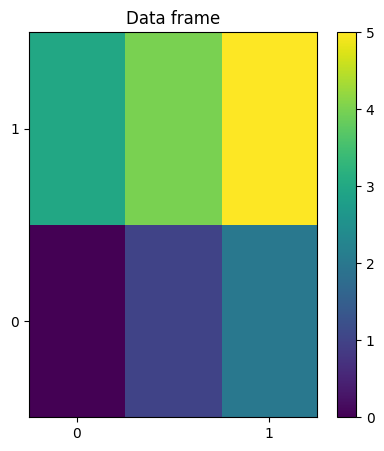

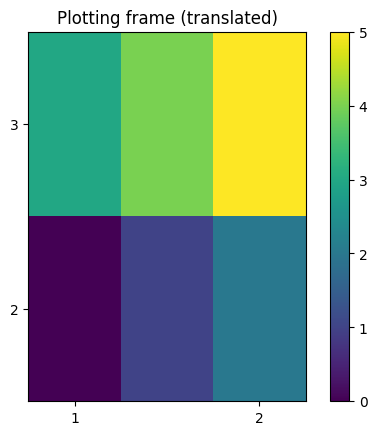

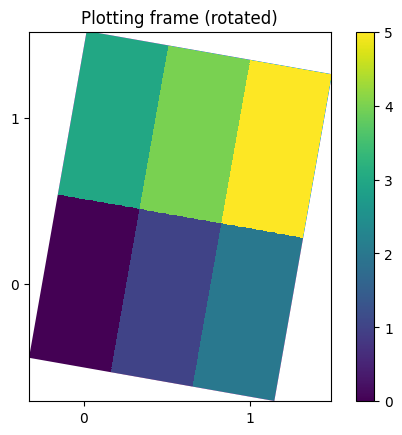

In [2]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MaxNLocator


def _get_extent(signal, axis0, axis1):
    assert signal.shape == (axis0.size, axis1.size)
    x0, x1 = axis1[[0, -1]]
    y0, y1 = axis0[[0, -1]]
    dx = (axis1[1] - axis1[0]) / 2
    dy = (axis0[1] - axis0[0]) / 2
    return x0 - dx, x1 + dx, y0 - dy, y1 + dy


def _get_transformed_extent(signal, axis0, axis1, active):
    xmin, xmax, ymin, ymax = _get_extent(signal, axis0, axis1)
    corners = [[xmin, ymin, 1], [xmax, ymin, 1], [xmin, ymax, 1], [xmax, ymax, 1]]
    corners = numpy.array(corners).T
    corners = active.dot(corners)
    xmin = corners[0].min()
    xmax = corners[0].max()
    ymin = corners[1].min()
    ymax = corners[1].max()
    return xmin, xmax, ymin, ymax


def _imshow(ax, signal, axis0, axis1):
    extent = _get_extent(signal, axis0, axis1)
    im = ax.imshow(signal, extent=extent, aspect="equal", origin="lower")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    xmin, xmax, ymin, ymax = extent
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return im


def plot_nxdata2d(signal, axis0, axis1, **kw):
    plt.figure(**kw)
    ax = plt.gca()
    im = _imshow(ax, signal, axis0, axis1)
    plt.colorbar(im)


def flip_xy(matrix):
    # [x,y,1] -> [y,x,1]
    matrix = matrix.copy()
    matrix[0:2, 0:2] = matrix[0:2, 0:2].T
    matrix[0:2, 2] = matrix[0:2, 2][::-1]
    return matrix


def plot_nxdata2d_transform(signal, axis0, axis1, passive_xy, **kw):
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/affine_image.html

    plt.figure(**kw)
    ax = plt.gca()
    im = _imshow(ax, signal, axis0, axis1)

    if passive_xy is not None:
        passive = numpy.asarray(passive_xy)
        active = numpy.linalg.inv(passive)
        transform = Affine2D(active)
        im.set_transform(transform + ax.transData)
        lims = _get_transformed_extent(signal, axis0, axis1, active)
        xmin, xmax, ymin, ymax = lims
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    plt.colorbar(im)


def plot_vector2d(ax, x0, y0, x1, y1, label):
    norm = ((x1 - x0) ** 2 + (y1 - y0) ** 2) ** 0.5
    ax.arrow(
        x0,
        y0,
        x1 - x0,
        y1 - y0,
        color="white",
        width=norm * 0.01,
        length_includes_head=True,
    )
    ax.text(x1, y1, label, color="white")


def test_plotting():
    kw = {"figsize": (5, 5)}

    # NXdata
    n0, n1 = 2, 3
    axis0 = numpy.arange(n0) / (n0 - 1)
    axis1 = numpy.arange(n1) / (n1 - 1)
    signal = numpy.arange(n0 * n1).reshape(n0, n1)

    # NXdata without reference frame
    # The coordinates are given with respect to the plot basis
    plot_nxdata2d(signal, axis0, axis1, **kw)
    plt.gca().set_title("Data frame")

    # NXdata with reference frame
    a = 10
    passive = [[1, 0, -1], [0, 1, -2], [0, 0, 1]]
    plot_nxdata2d_transform(signal, axis0, axis1, passive)
    plt.gca().set_title("Plotting frame (translated)")

    # NXdata with reference frame
    a = 10
    passive = [[cos(a), -sin(a), 0], [sin(a), cos(a), 0], [0, 0, 1]]
    plot_nxdata2d_transform(signal, axis0, axis1, passive)
    plt.gca().set_title("Plotting frame (rotated)")


test_plotting()

## Saving

Utilities for reading and writing NXdata

In [3]:
import os
import tempfile
import h5py


def get_filename():
    return os.path.join(tempfile.gettempdir(), "nxdata_transform_example.h5")


def save_nxdata(name, signal, axis0, axis1, title, passive_xyz=None):
    if passive_xyz is None:
        mode = "w"
    else:
        mode = "a"
    with h5py.File(get_filename(), mode=mode) as root:
        if passive_xyz is None:
            root.attrs["NX_class"] = "NXroot"
            root.attrs["default"] = "entry"
            entry = root.create_group("entry")
            entry.attrs["NX_class"] = "NXentry"
        else:
            entry = root["entry"]
        data = entry.create_group(name)
        entry.attrs["default"] = name
        data.attrs["NX_class"] = "NXdata"
        data.attrs["signal"] = "data"
        data.attrs["axes"] = [axis0["name"], axis1["name"]]
        data["title"] = title
        data["data"] = signal
        data[axis0["name"]] = axis0["value"]
        data[axis1["name"]] = axis1["value"]
        data[axis0["name"]].attrs["long_name"] = axis0["title"]
        data[axis1["name"]].attrs["long_name"] = axis1["title"]
        if passive_xyz is not None:
            data.attrs["passive_transformation"] = "transform"
            passive_xy = numpy.identity(3)
            passive_xy[:2, :2] = passive_xyz[:2, :2]
            passive_xy[:2, -1] = passive_xyz[:2, -1]
            data["transform"] = flip_xy(passive_xy)


def plot_nxdata(name, figsize=(10, 10)):
    with h5py.File(get_filename(), mode="r") as root:
        data = root["entry"][name]
        signal = data[data.attrs["signal"]]
        axis0 = data[data.attrs["axes"][0]]
        axis1 = data[data.attrs["axes"][1]]

        transform_name = data.attrs.get("passive_transformation")
        if transform_name is None:
            plot_nxdata2d(signal, axis0, axis1, figsize=(10, 10))
        else:
            passive = flip_xy(data[transform_name][()])
            plot_nxdata2d_transform(signal, axis0, axis1, passive, figsize=figsize)
        ax = plt.gca()
        ax.set_title(data["title"][()].decode())
        ax.set_xlabel(axis1.attrs["long_name"])
        ax.set_ylabel(axis0.attrs["long_name"])

# Examples

## NXdata crystallography example

Assume we measure a diffraction signal in reciprocal space with coordinates in HKL space and we want to plot the data in direct or reciprocal space.

In [4]:
# Lattice in direct space
lattice = {"a": 1, "b": 2, "c": 1, "alpha": 90, "beta": 90, "gamma": 120}

Regular sampling grid in HKL space

In [5]:
haxis = numpy.linspace(-1.5, 1.5, 400)
kaxis = numpy.linspace(-1.5, 1.5, 400)
h, k = numpy.meshgrid(haxis, kaxis, indexing="xy")
shape = h.shape
h = h.flatten()
k = k.flatten()
l = numpy.zeros_like(h)
HKL = numpy.stack([h, k, l], axis=1)

NXdata axes and signal: diffraction signal with pixel axes

In [6]:
# Laue conditions for diffraction
Q = 2 * numpy.pi * HKL

# Number of unit cells in each direction
N = [3, 3, 3]

signal = simplified_diffraction(Q, numpy.identity(3), N).reshape(shape)

hmin = haxis[0]
dh = haxis[1] - haxis[0]
kmin = kaxis[0]
dk = kaxis[1] - kaxis[0]

axis1 = (haxis - hmin) / dh
axis0 = (kaxis - kmin) / dk

Save NXdata with different passive transformations

In [7]:
axis0 = {"name": "y", "value": axis0}
axis1 = {"name": "x", "value": axis1}

axis0["title"] = "Y (pixels)"
axis1["title"] = "X (pixels)"
save_nxdata("raw", signal, axis0, axis1, "Raw data frame")

passive_data_to_reciprocal = numpy.identity(4)
passive_data_to_reciprocal[0, -1] = -hmin / dh
passive_data_to_reciprocal[1, -1] = -kmin / dk
passive_data_to_reciprocal[0, 0] = 1 / dh
passive_data_to_reciprocal[1, 1] = 1 / dk

axis0["title"] = "b*"
axis1["title"] = "a*"
save_nxdata(
    "reciprocal",
    signal,
    axis0,
    axis1,
    "Reciprocal frame",
    passive_xyz=passive_data_to_reciprocal,
)

print("Passive transformation: Reciprocal frame")
print(passive_data_to_reciprocal)

B = busing_levy_reciprocal_basis(lattice)
passive_reciprocal_to_standard = numpy.identity(4)
passive_reciprocal_to_standard[:3, :3] = numpy.linalg.inv(B)

passive_data_to_standard = passive_data_to_reciprocal.dot(
    passive_reciprocal_to_standard
)

axis0["title"] = "e1"
axis1["title"] = "e0"
save_nxdata(
    "standard",
    signal,
    axis0,
    axis1,
    "Standard Euclidean frame",
    passive_xyz=passive_data_to_standard,
)

print("\nPassive transformation: Standard Euclidean frame")
print(passive_data_to_standard)

Passive transformation: Reciprocal frame
[[133.    0.    0.  199.5]
 [  0.  133.    0.  199.5]
 [  0.    0.    1.    0. ]
 [  0.    0.    0.    1. ]]

Passive transformation: Standard Euclidean frame
[[ 1.15181379e+02 -6.65000000e+01 -1.11247759e-14  1.99500000e+02]
 [ 0.00000000e+00  2.66000000e+02  1.62878024e-14  1.99500000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


The final plot we want to show

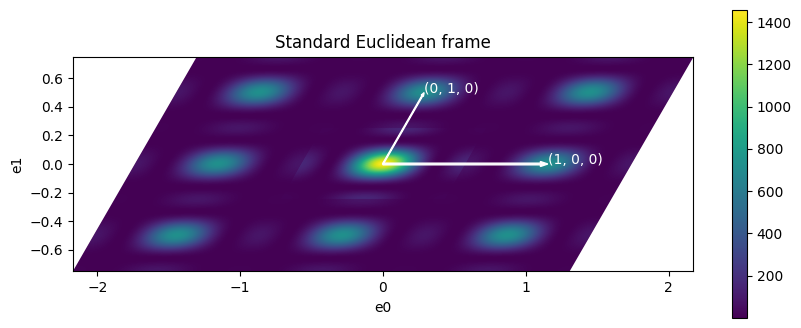

In [8]:
passive_xyz = passive_data_to_standard
passive_xy = numpy.identity(3)
passive_xy[:2, :2] = passive_xyz[:2, :2]
passive_xy[:2, -1] = passive_xyz[:2, -1]

plot_nxdata2d_transform(
    signal, axis0["value"], axis1["value"], passive_xy, figsize=(10, 4)
)

ax = plt.gca()
ax.set_title("Standard Euclidean frame")
ax.set_xlabel("e0")
ax.set_ylabel("e1")

rlattice = lattice_to_reciprocal_lattice(lattice)
ra = rlattice["a"]
rb = rlattice["b"]
rab = rlattice["gamma"]

plot_vector2d(ax, 0, 0, ra, 0, "(1, 0, 0)")
plot_vector2d(ax, 0, 0, rb * cos(rab), rb * sin(rab), "(0, 1, 0)")

Plot data without transformation

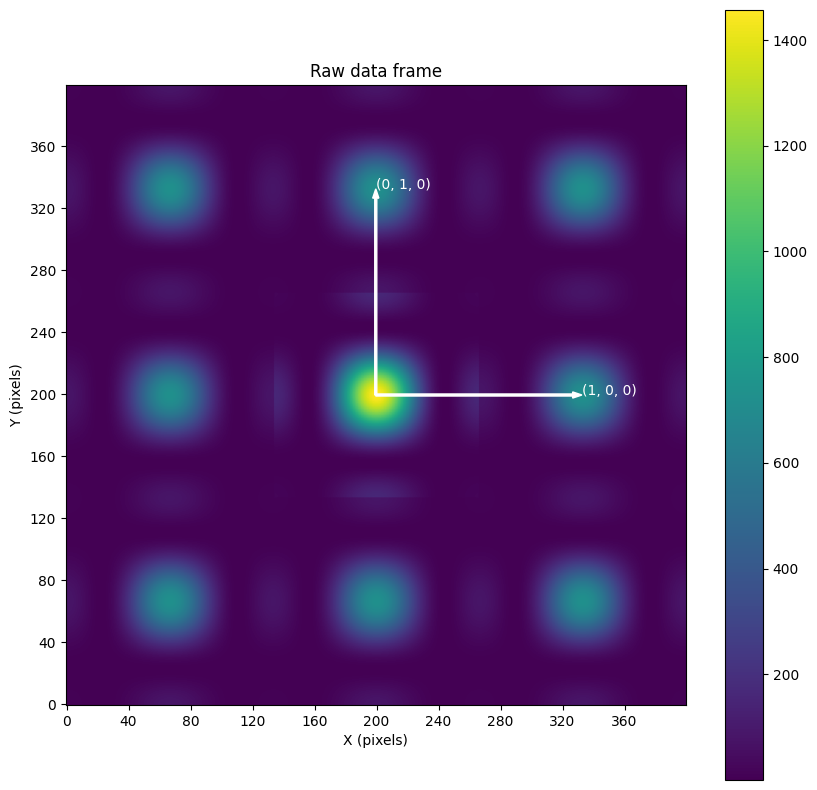

In [9]:
plot_nxdata("raw")

ax = plt.gca()
x0, y0, *_ = passive_data_to_reciprocal.dot([0, 0, 0, 1])[:2]
x1, y1, *_ = passive_data_to_reciprocal.dot([1, 0, 0, 1])[:2]
plot_vector2d(ax, x0, y0, x1, y1, "(1, 0, 0)")
x1, y1, *_ = passive_data_to_reciprocal.dot([0, 1, 0, 1])[:2]
plot_vector2d(ax, x0, y0, x1, y1, "(0, 1, 0)")

Plot data in reciprocal space

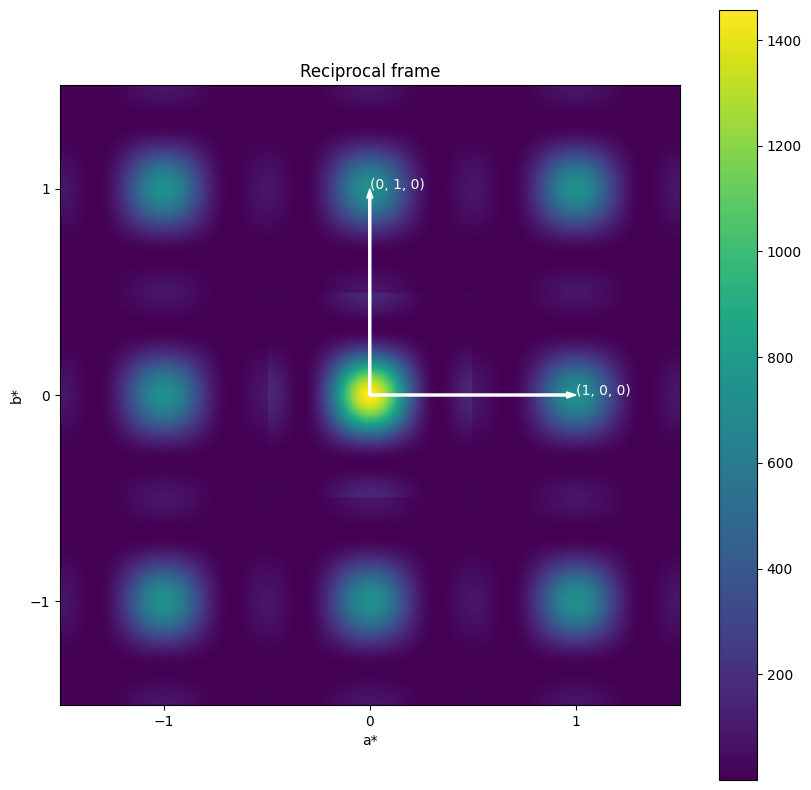

In [10]:
plot_nxdata("reciprocal")

ax = plt.gca()
plot_vector2d(ax, 0, 0, 1, 0, "(1, 0, 0)")
plot_vector2d(ax, 0, 0, 0, 1, "(0, 1, 0)")

Plot data in the standard Euclidean frame

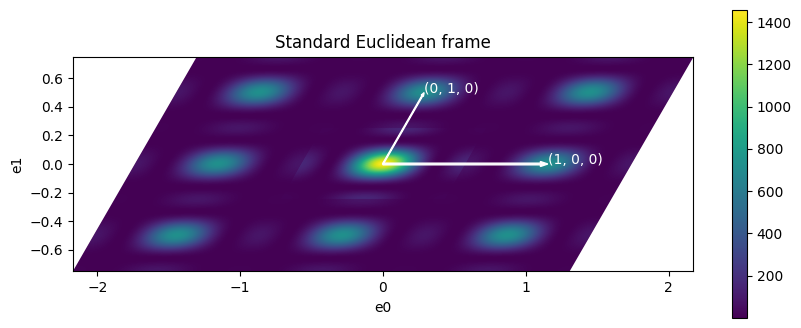

In [11]:
plot_nxdata("standard", figsize=(10, 4))

reciprocal_to_standard = numpy.identity(4)
reciprocal_to_standard[:3, :3] = B

ax = plt.gca()
x0, y0, *_ = reciprocal_to_standard.dot([0, 0, 0, 1])[:2]
x1, y1, *_ = reciprocal_to_standard.dot([1, 0, 0, 1])[:2]
plot_vector2d(ax, x0, y0, x1, y1, "(1, 0, 0)")
x1, y1, *_ = reciprocal_to_standard.dot([0, 1, 0, 1])[:2]
plot_vector2d(ax, x0, y0, x1, y1, "(0, 1, 0)")